In [2]:
import numpy as np
import pandas as pd
import imageio

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner



Defining an EV dispatch space as a class and spaces with a constructor to define each EV space occupied in the grid as 'Available'. In order to establish sequential energy dispatch, step function has been defined considering availiblity of EV in the space followed by 'Discharging' state to the adjacent occupied state on Von Neumann (up/down/left and right) aggregation followed by 'Discharged Space' further ending the participation.



In [16]:
class EVSpace(Agent):

    #Space has been defined using pos with unique_id: (x,y)

    def __init__(self, model, pos):

    #Creating EV agent space for the environment
    
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Available"
        #print("Agent "+str(self.unique_id)+" is available.")
        
    def step(self):
     #Initial Step for assesing and segregating charging, discharging and avaiable EVs at step. 

        if self.condition == "Charging":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=True)
            for neighbor in neighbors:
                if neighbor.condition == "Available":
                    neighbor.condition = "Charging"
            self.condition = "Discharged"
            #print("Agent "+str(self.unique_id)+" has participated")

EV Dispatch space has been defined with the height and width, density parameters taken as a parameters individually as established in the supplementary spreadsheet 'V2G scenario evaluation'.

In an ideal case, assuming all the EVs are injecting power into the grid, There remains three state 'Available' and 'Discharging'  for an occupied EV with an assigned co-ordinate (x,y).

The second progressing step for discharging to advance model by one step.

In [19]:
class EVDispatch(Model):
    
    def __init__(self, height, width, density):
       #Model Parameters: Creating height, width for the environment.   
    
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        
        #Two conditions for simulating the co-ordinated charging scheme.
        
        self.dc = DataCollector({"Available": lambda m: self.count_type(m, "Available"),
                                "Charging": lambda m: self.count_type(m, "Charging")})
        
        # Place an EV in each cell with Prob = density with a random distribution. 
        for x in range(self.width):
            for y in range(self.height):
                if self.random.random() < self.density:
                    # Create an EV
                    new_ev = EVSpace(self, (y, x))
                    # Set all EVs in the first column charging.
                    if x == 0:
                        new_ev.condition = "Charging"
                        
                    self.grid[y][x] = new_ev
                    self.schedule.add(new_ev)


        self.running = True
        
    def step(self):
      #Advancing model to the next step
    
        self.schedule.step()
        self.dc.collect(self)
       #Stop the cycle in case all the EVs have been charged once. 
        if self.count_type(self, "Charging") == 0:
            self.running = False

    @staticmethod
    def count_type(model, ev_condition):
        '''
        Helper method to count EVs in a given condition in a given model.
        '''
        count = 0
        for ev in model.schedule.agents:
            if ev.condition == ev_condition:
                count += 1
        return count


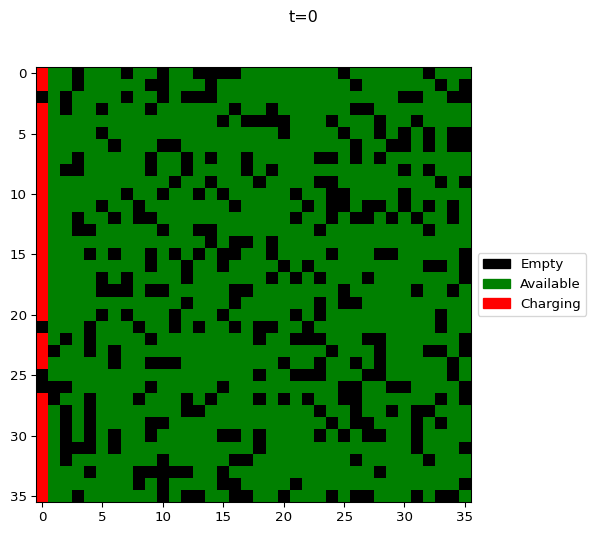

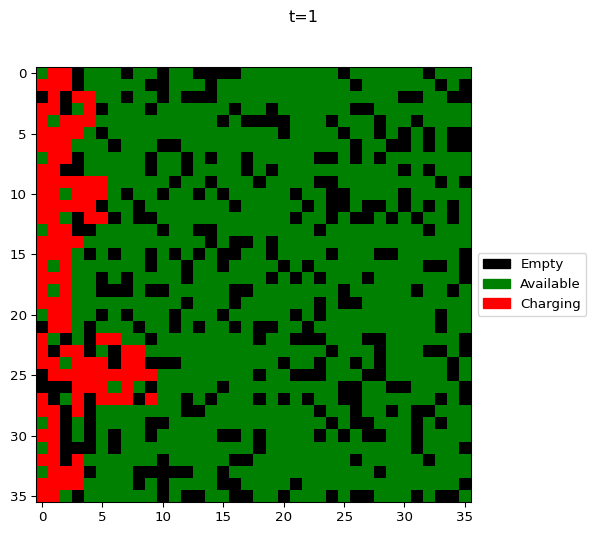

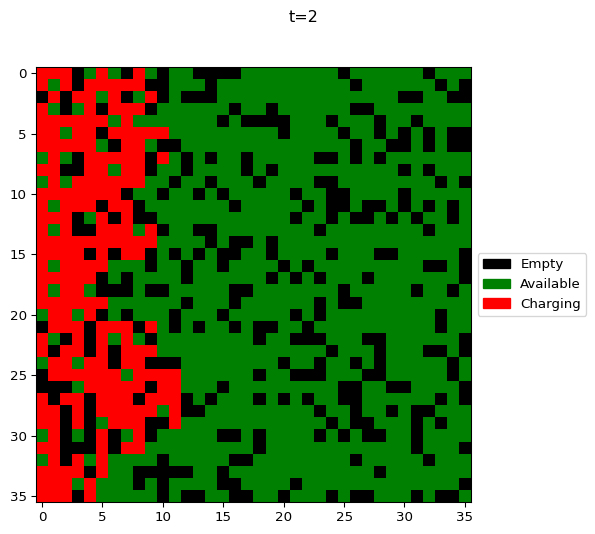

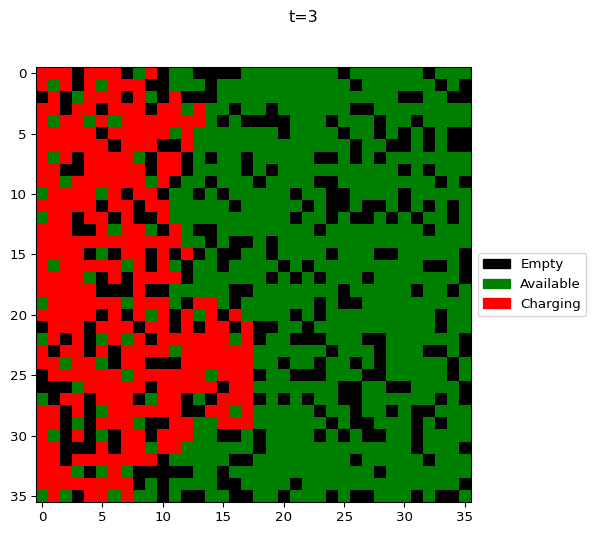

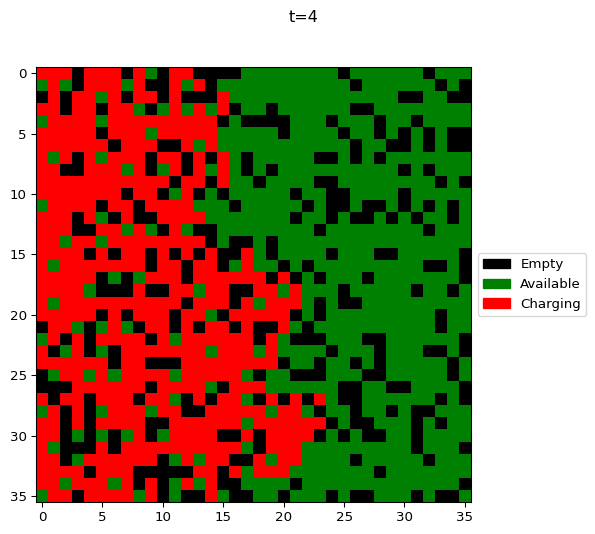

Created file: abm_movie.gif


In [23]:
timesteps = 5
model = EVDispatch(367,367,0.77) #Create Model as an object
figsize = (8, 6) # figure size in inches

allsteps = []

for t in range(timesteps):
    # Store the model state
    for agent in model.schedule.agents:
        allsteps.append((t, agent.pos, agent.condition))
    # Run the model
    model.step()

# Store the final model state
for agent in model.schedule.agents:
    allsteps.append((timesteps, agent.pos, agent.condition))

df = pd.DataFrame(allsteps, columns = ['t', 'pos', 'state'])

# populate a grid with agents for visualisation
# values:
#   0: empty cell
#   1: healthy ev
#   2: charging
#   3: participated

filelist = [] # store list of file names of grid maps

for t in range(timesteps):
    cells = np.zeros((model.grid.width, model.grid.height))
    this_agent_team = df.loc[df['t'] == t]
    #print(this_agent_team)
    n_agents = this_agent_team.shape[0]
    for this_agent in range(this_agent_team.shape[0]):
        y = this_agent_team.loc[t * n_agents + this_agent]['pos'][0]
        x = this_agent_team.loc[t * n_agents + this_agent]['pos'][1]
        this_agent_state = this_agent_team.loc[t * n_agents + this_agent]['state']
        if this_agent_state == 'Available':
            cell = 1
        if this_agent_state == 'Charging':
            cell = 2
        cells[y,x] = cell
   

    # ------- begin plotting ---------------------

    # make a custom colour map, see https://www.rapidtables.com/web/color/RGB_Color.html
    n = 4 # number of discrete values or possible states of the cells

    # create n+1 boundaries to have n colour bar intervals
    boundaries = np.arange(-0.5, n+1.5, 1.)

    # create list of n+1 colours from colormap
    cmap_reds = plt.cm.get_cmap('Reds', len(boundaries))
    colours = list(cmap_reds(np.arange(len(boundaries))))

    # replace colours with our own colour scheme
    colours[0] = "black"
    colours[1] = "green"
    colours[2] = "red"
    

    mycmp = matplotlib.colors.ListedColormap(colours[:-1], "")
    mycmp.set_over(colours[-1]) # set over-colour to last colour of list 

    fig = plt.figure(figsize=figsize, dpi=96, facecolor='w') # create a figure
    ax = plt.subplot(111) # add an axis object

    # Shrink current axis by 20% to make room for the legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    legend_elements = [Patch(facecolor=colours[0], edgecolor=colours[0], label='Empty'),
                      Patch(facecolor=colours[1], edgecolor=colours[1], label='Available'),
                      Patch(facecolor=colours[2], edgecolor=colours[2], label='Charging')
                      ]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # add a figure title
    fig.suptitle('t='+str(t))
    
    # show the plot on screen
    cm = plt.imshow(cells, cmap=mycmp,
        norm = matplotlib.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
    )
    plt.show()
    
    # save the plot
    filename = "evcharge_" + str(t) + ".jpg"
    fig.savefig(filename)
    filelist.append(filename)
    plt.close()
    # ------- end of plotting ---------------------

imagestack = []
for filename in filelist:
    imagestack.append(imageio.imread(filename))
kargs = { 'duration': 0.5 }
imageio.mimsave('abm_movie.gif', imagestack, loop=0, **kargs)
print('Created file: abm_movie.gif')


In [15]:
discharge = EVDispatch(224, 224, 0.77)
discharge.run_model()
results = discharge.dc.get_model_vars_dataframe()
print(results)


    Available  Charging
0       37976       312
1       37338       336
2       36649       373
3       35878       393
4       35041       422
5       34304       366
6       33644       339
7       32963       361
8       32303       349
9       31622       368
10      30983       324
11      30299       372
12      29547       394
13      28787       408
14      28126       346
15      27462       335
16      26655       418
17      25975       379
18      25282       372
19      24618       372
20      23949       358
21      23255       370
22      22552       368
23      21844       360
24      21062       404
25      20365       373
26      19709       346
27      19016       379
28      18348       348
29      17559       413
30      16830       386
31      16087       409
32      15408       362
33      14719       354
34      14044       351
35      13284       385
36      12514       410
37      11803       370
38      11110       377
39      10407       386
40       9697   

In [45]:
results.to_csv(r'C:\Users\k_gag\OneDrive\Desktop\Dissertation_V2G\results\vehicle30812.csv')

In [ ]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()
